# Intro to Random Forests applied to Kaggle competition: Forest Cover Type

In this notebook I will apply the Random Forests and what I learned in the Fast.ai lesson 1 and 2 to the competition

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sklearn

In [ ]:
#!pip3 install sklearn_pandas

In [ ]:
#!pip3 install pandas_summary

In [1]:
from fastai.imports import *
from fastai.structured import *

C:\Users\France\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "../../data/forests/"

## The data

### Look at the data

For this competition, you are predicting an integer classification for the forest cover type.
The seven types are:

1 - Spruce/Fir
2 - Lodgepole Pine
3 - Ponderosa Pine
4 - Cottonwood/Willow
5 - Aspen
6 - Douglas-fir
7 - Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

Submissions are evaluated on multi-class classification accuracy.

The files are:
- test.csv test file
- train.csv train file

Evaluation:
Submissions are evaluated on multi-class classification accuracy.

Reading the training set

In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)
#parse dates transforms the saledates into a date format object, it is a panda function

In [7]:
df_raw.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
display_all(df_raw.tail().T)

In [ ]:
display_all(df_raw.describe(include='all').T)

In [14]:
df_raw.shape

(15120, 56)

In [15]:
df_raw.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

# The steps
I am following the steps suggested in the course fast.ai.
1. create a dataframe without the dependent variable an convert it to array 
2. create an array of lables of the categories
3. split the set into train and validation

This can be done mannually as below or using the function proc_df which does it automatically for you, just need to pass the dependent variable name.

Other useful methods:
train_cats(df) to converts strings into pandas categories. Creates a number and store a mapping of it. Because we do not have strings, this does not apply.




In [16]:
feature_list = list(df_raw.columns)

In [18]:
labels

array([5, 5, 2, ..., 3, 3, 3], dtype=int64)

In [19]:
features

array([[    1,  2596,    51, ...,     0,     0,     5],
       [    2,  2590,    56, ...,     0,     0,     5],
       [    3,  2804,   139, ...,     0,     0,     2],
       ...,
       [15118,  2492,   134, ...,     0,     0,     3],
       [15119,  2487,   167, ...,     0,     0,     3],
       [15120,  2475,   197, ...,     0,     0,     3]], dtype=int64)

## Creating arrays for lables and dataset

In [6]:
#We will replace categories with their numeric codes, handle missing continuous values, 
#and split the dependent variable into a separate variable.
df_trn, y_trn, nas=proc_df(df_raw, 'Cover_Type') #dataframe, labels and empty

In [7]:
len(df_trn)

15120

## Splitting values and training on a subset

In [8]:
def split_vals(a,n): return a[:n], a[n:]



def print_score(m):
    # Use the forest's predict method on the test data
    predictions = m.predict(X_valid)
    # Calculate the absolute errors
    errors = abs(predictions - y_valid)
# Print out the mean absolute error (mae)
    print(predictions)
    print(errors)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_valid)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    res = [m.predict(X_train), y_train, m.predict(X_valid), y_valid,
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
        print('oob score is ', m.oob_score_)
   # print(res)

In [176]:
#creating a subset and splitting it
df_trn, y_trn, nas = proc_df(df_raw, 'Cover_Type', subset= 10000)
X_train, _ = split_vals(df_trn, 5000) #resampling the training set of 20.000 out of 30.000
y_train, _ = split_vals(y_trn, 5000)

In [150]:
y_trn #the labels

array([5, 5, 2, ..., 3, 3, 3], dtype=int64)

In [97]:
#n_estimators are the trees, maxdepth bootstrap=False set out some randomizing
# a tree is a binary splits, True / False
# the average is the value, the mean squared error is mse, this is the denominator of R2

m =  RandomForestClassifier(n_estimators =1, max_depth=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\France\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\France\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Wall time: 133 ms
[6 5 7 ... 5 5 5]
[0 2 6 ... 0 4 3]
Mean Absolute Error: 1.77 degrees.
0.2298


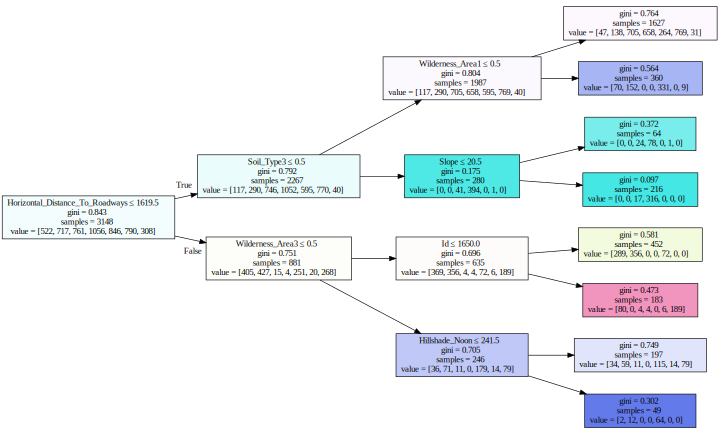

In [98]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [177]:
#rerun without subsampling
n_valid = 12000
n_trn = len(df_trn)-n_valid
df_trn, y_trn, nas = proc_df(df_raw, 'Cover_Type')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [178]:
X_train.shape, y_train.shape, X_valid.shape

((13120, 55), (13120,), (2000, 55))

- min_samples:  Stop training the tree further when a leaf node has 3 or less samples 
(before we were going all the way down to 1).This means there will be one or two less levels of decision being made which means there are half the number of actual decision criteria we have to train (i.e. faster training time).
- max_features=0.5 : The idea is that the less correlated your trees are with each other, the better. In addition to taking a subset of rows, at every single split point, take a different subset of columns.

In [182]:

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, 
                          n_jobs=-1, oob_score=True) 

m.fit(X_train, y_train)

print_score(m)

[4 3 3 ... 3 3 3]
[0 0 1 ... 0 0 0]
Mean Absolute Error: 0.52 degrees.
Accuracy: 74.54 %.
oob score is  0.8497713414634146


In [166]:
score=m.predict(X_valid)

In [167]:
score

array([4, 4, 3, ..., 2, 2, 2], dtype=int64)

In [186]:
m = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=2, max_features=0.5,
                          n_jobs=-1, oob_score=True, random_state=30) 

m.fit(X_train, y_train) 
print_score(m)

[4 3 3 ... 3 3 3]
[0 0 1 ... 0 0 0]
Mean Absolute Error: 0.66 degrees.
Accuracy: 74.98 %.
oob score is  0.8692073170731708


In [194]:
m = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=2, max_features=20,
                          n_jobs=-1, oob_score=True, random_state=20) 

m.fit(X_train, y_train) 
print_score(m)

[4 3 3 ... 3 3 3]
[0 0 1 ... 0 0 0]
Mean Absolute Error: 0.55 degrees.
Accuracy: 73.47 %.
oob score is  0.8746951219512196


In [196]:
m = RandomForestClassifier(n_estimators=250, max_depth=20, min_samples_leaf=2, max_features=20,
                          n_jobs=-1, oob_score=True, random_state=20) 

m.fit(X_train, y_train) 
print_score(m)

[4 3 3 ... 3 3 3]
[0 0 1 ... 0 0 0]
Mean Absolute Error: 0.52 degrees.
Accuracy: 76.59 %.
oob score is  0.8825457317073171


In [213]:
m = RandomForestClassifier(n_estimators = 2000, random_state = 42, oob_score=True) 

m.fit(X_train, y_train) 
print_score(m)

[4 3 3 ... 3 3 3]
[0 0 1 ... 0 0 0]
Mean Absolute Error: 0.46 degrees.
Accuracy: 77.32 %.
oob score is  0.8871951219512195


In [171]:
#filename = r"../input/test.csv"
filename = f"{PATH}test.csv"
df_test = pd.read_csv(filename)
#x_test = x_test.values
x_test, y, nas= proc_df(df_test, subset= 100)

In [173]:
y_predict = m.predict(x_test)

In [174]:
y_predict[:10]

array([1, 1, 2, 2, 2, 2, 2, 2, 1, 2], dtype=int64)

In [133]:

csvfile = open("sample_submission1.csv", "w", encoding="gb18030", newline="")
writer = csv.writer(csvfile)
writer.writerow(["ID", "Cover_Type"])
for i in range(len(y_predict)):
    x = [x_test[i,0], y_predict[i]]
    writer.writerow(x)
csvfile.close()

There will be quite a few hyper parameters that we are going to set and we would like to find some automated say to set them. One way to do that is to do grid search. Scikit-learn has a function called grid search and you pass in a list of all the hyper parameters you want to tune and all of the values of these hyper parameters you want to try. It will run your model on every possible combination of all these hyper parameters and tell you which one is the best. OOB score is a great choice for getting it to tell you which one is the best.

# Other method
Since I was unable to import some of the function of fast.ai in Kaggle, still not solved, I have used the same solution but with different code. The result is a Accuracy: 85.9 % which is not too bad for the first try. The real accuracy in Kaggle resulted in 77%, still work to do.

In [197]:
# Use numpy to convert to arrays
#code from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# Labels are the values we want to predict
labels = np.array(df_raw['Cover_Type'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_raw.drop('Cover_Type', axis = 1)
# Saving feature names for later use

# Convert to numpy array
df_trn = np.array(features)


In [198]:
labels.shape, df_trn.shape

((15120,), (15120, 55))

In [190]:
features


array([[    1,  2596,    51, ...,     0,     0,     5],
       [    2,  2590,    56, ...,     0,     0,     5],
       [    3,  2804,   139, ...,     0,     0,     2],
       ...,
       [15118,  2492,   134, ...,     0,     0,     3],
       [15119,  2487,   167, ...,     0,     0,     3],
       [15120,  2475,   197, ...,     0,     0,     3]], dtype=int64)

In [9]:
df_trn, labels, nas=proc_df(df_raw, 'Cover_Type') #dataframe, labels and empty

In [189]:
df_trn.shape, labels.shape

((15120, 55), (15120,))

In [199]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_trn, labels, test_size = 0.25, random_state = 42)

In [200]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (11340, 55)
Training Labels Shape: (11340,)
Testing Features Shape: (3780, 55)
Testing Labels Shape: (3780,)


In [225]:
??RandomForestClassifier

In [201]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 280, random_state = 45, oob_score=True, min_samples_leaf=1, max_depth=35)
# Train the model on training data
rf.fit(train_features, train_labels);

In [202]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print(predictions)
print(test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

[6 3 1 ... 2 1 6]
[6 3 1 ... 5 1 2]
Mean Absolute Error: 0.29 degrees.


In [203]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 85.2 %.


In [204]:
rf = RandomForestClassifier(n_estimators=250, max_depth=35, min_samples_leaf=1, max_features=10,
                          n_jobs=-1, oob_score=True, random_state=45) 

rf.fit(train_features, train_labels);

In [205]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print(predictions)
print(test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

[6 3 1 ... 2 1 2]
[6 3 1 ... 5 1 2]
Mean Absolute Error: 0.28 degrees.


In [206]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 85.9 %.


In [149]:
#filename = r"../input/test.csv"
filename = f"{PATH}test.csv"
df_test = pd.read_csv(filename)
#x_test = x_test.values
x_test, y, nas= proc_df(df_test)

In [156]:
y_predict = rf.predict(x_test)

In [170]:
len(y_predict)

565892

In [183]:
#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'Id':x_test["Id"],'Cover_Type':y_predict}).sort_index(axis=1)

#Visualize the first 5 rows
submission.sort_index(axis=1).head()

,Cover_Type,Id
0,1,15121
1,1,15122
2,2,15123
3,2,15124
4,2,15125


In [185]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'F_submission2.csv'

submission.to_csv(filename,index=True)

print('Saved file: ' + filename)

Saved file: F_submission2.csv


In [ ]:
csvfile = open("./submissions/sample_submission3.csv", "w", encoding="utf8", newline="")
writer = csv.writer(csvfile)
writer.writerow(["ID", "Cover_Type"])
for i in range(len(y_predict)):
    x = [x_test[i,0], y_predict[i]]
    writer.writerow(x)
csvfile.close()